In [1]:
import torch
import pandas as pd
import os
main_dir = '../wind-profiles'
#directories = ['CR1992', 'CR2056', 'CR2071', 'CR2125', 'CR2210']
directories = []
total_size = 640
segment_to_skip = 503

# three dimensional tensors, with shape (len(dir), 640, 9) and (len(dir), 640, 3)
X_data = torch.empty(0, total_size - segment_to_skip, 4)
y_data = torch.empty(0, total_size - segment_to_skip, 3)

for directory in directories:
    for file_ in os.listdir(f'{main_dir}/{directory}'):
        data = pd.read_csv(f'{main_dir}/{directory}/{file_}', delimiter=',', 
                        header=0, names=['R', 'L', 'Lon', 'Lat', 'n', 'v', 'T', 'B', 'A/A0', 'alpha', 'V/Cs', 'propag_dt'], 
                        skiprows=2, dtype=float, na_values=['                      NaN', '                     -NaN'])
        
        # if data has NaN values in R column, continue to next file
        if data[['R', 'B', 'alpha', 'n', 'v', 'T']].isnull().values.any():
            continue
        
        # convert to tensor, with shape (len(data), 3), where the three channels are R, B, alpha
        X_sample = torch.tensor(data[['R', 'L', 'B', 'alpha']].values, dtype=torch.float32)
        y_sample = torch.tensor(data[['n', 'v', 'T']].values, dtype=torch.float32)
        
        X_data = torch.cat((X_data, X_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)
        y_data = torch.cat((y_data, y_sample[segment_to_skip:, :].unsqueeze(0)), dim=0)

In [2]:
# load tensors from file
X_data = torch.load('X_data.pt')
y_data = torch.load('y_data.pt')

In [122]:
# permute the last two dimensions of the tensor
X_data = X_data.permute(0, 2, 1)
y_data = y_data.permute(0, 2, 1)

In [3]:
y_data.shape

torch.Size([12940, 3, 137])

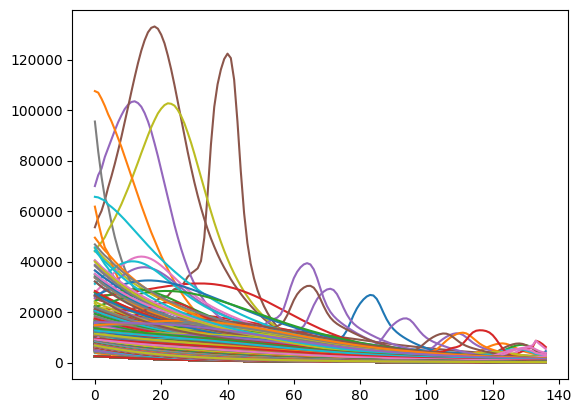

In [15]:
# plot n values in y_data
import matplotlib.pyplot as plt
plt.plot(y_data[:, 0, :].T)
plt.show()

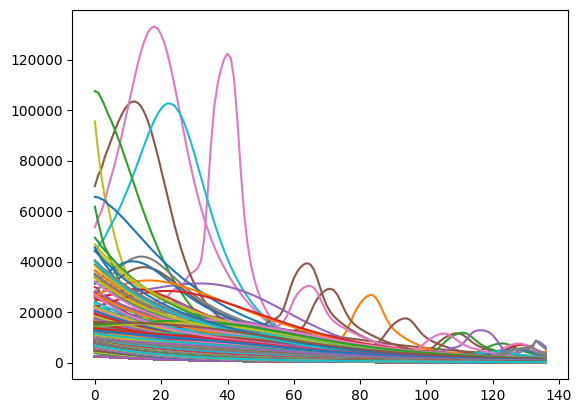

In [6]:
# n values are oscillating, so we need to smooth them
import torch.nn.functional as F
y_data[:, 0, 4:133] = F.avg_pool1d(y_data[:, 0, :].unsqueeze(1), kernel_size=9, stride=1, ceil_mode=True).squeeze()
plt.plot(y_data[:, 0, :].T)
plt.show()

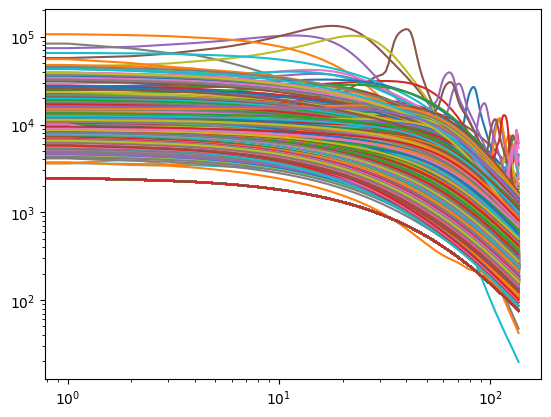

In [16]:
plt.loglog(y_data[:, 0, :].T)
plt.show()

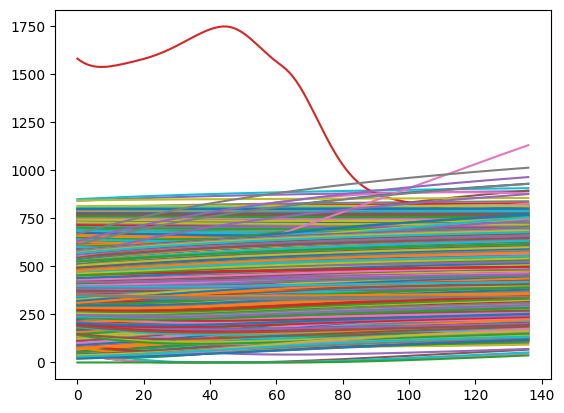

In [9]:
plt.plot(y_data[:, 1, :].T)
plt.show()

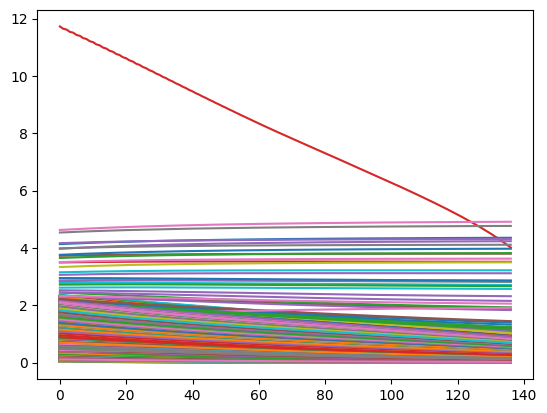

In [10]:
plt.plot(y_data[:, 2, :].T)
plt.show()

In [11]:
# detect outlier that has values over 5 on the third channel
outliers = y_data[:, 2, :] > 6
outliers = torch.sum(outliers, dim=1)

# get the indices of the outliers
outliers = torch.nonzero(outliers)
outliers

tensor([[1503]])

C:\Users\nrtc\AppData\Local\Temp\ipykernel_5188\3092750502.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3641.)
  plt.plot(y_data[1503, 2, 40:].T)


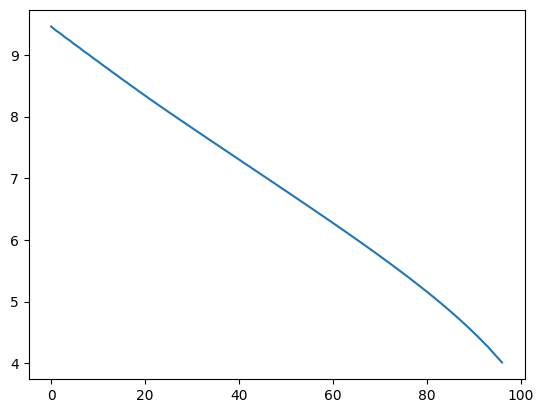

In [12]:
# plot 1503th sample
plt.plot(y_data[1503, 2, 40:].T)
plt.show()

In [13]:
# remove the outlier
X_data = torch.cat((X_data[:1503, :, :], X_data[1504:, :, :]), dim=0)
y_data = torch.cat((y_data[:1503, :, :], y_data[1504:, :, :]), dim=0)

In [14]:
# save tensors to file
torch.save(X_data, 'X_data.pt')
torch.save(y_data, 'y_data.pt')